In [330]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [285]:
class moment:
    '''
        moment class
    '''
    def __init__(self, gamma):
        self.gamma = gamma
        self.m = np.array([0, 0, 1])
        self.B = np.array([0, 0, 0])
        
    
    def m_cross_B(self, dt, m, B):
        '''
            Calculate \gamma * m \times B * \Delta t.
        '''
        a = self.gamma * (m[1] * B[2] - m[2] * B[1]) * dt
        b = self.gamma * (m[2] * B[0] - m[0] * B[2]) * dt
        c = self.gamma * (m[0] * B[1] - m[1] * B[0]) * dt
        return np.array([a, b, c])
        
    def update_m(self, dt):
        '''
            Calculate and update momentum value with Runge-Kutta 4th order method.
            For dt = 0.002, B = 1, error < 1e-14 after 30000 steps.
        '''
        # RK4
        
        k1 = self.m_cross_B(dt, self.m, self.B)
        
        m_temp = self.m + k1 / 2
        k2 = self.m_cross_B(dt, m_temp, self.B)
        
        m_temp = self.m + k2 / 2
        k3 = self.m_cross_B(dt, m_temp, self.B)
        
        m_temp = self.m + k3
        k4 = self.m_cross_B(dt, m_temp, self.B)
        
        self.m = self.m + (k1 + 2*k2 + 2*k3 + k4) / 6
        
        # direct calculation (for comparison only, avoid using in calculations!)
        # self.m = self.m + self.m_cross_B(dt, self.m, self.B)
        
        return

In [858]:
class crystal:
    def __init__(self, N_1, N_2, N_3):
        (self.N_1, self.N_2, self.N_3) = (N_1, N_2, N_3)
        self.a = 1 # lattice constant
        self.time = 0 # current evolution time
        self.gamma = 1 # gyromagnetic ratio
        self.B_0 = 1 # externel magnetic field strength
        self.B_ext = self.B_0 * np.array([0, 0, 1])
        self.moments = []
    
    def create(self):
        '''
            Create moments array of N_1 * N_2 * N_3.
            Initialize all moments to be:
                moment.gamma = self.gamma
                moment.m = np.array([0, 0, 1])
                moment.B = np.array([0, 0, 0])
        '''
        self.gamma = 2 * np.pi / np.sqrt(self.B_0**2 + 1)
        self.B_ext = self.B_0 * np.array([0, 0, 1])
        self.moments = [[[moment(self.gamma) for i in range(self.N_3)] for j in range(self.N_2)] for k in range(self.N_1)]
        self.info()
        return
    
    def info(self):
        '''
            Print current information.
        '''
        print("Current time: t = {0:.3f};".format(self.time))
        print(f"Crystal size: ({self.N_1}, {self.N_2}, {self.N_3});")
        print(f"Total moments amount: N = {self.N_1 * self.N_2 * self.N_3};")
        print(f"External field strength: B_0 = {self.B_0};")
        print(f"External field: B_ext = [{self.B_ext[0]}, {self.B_ext[1]}, {self.B_ext[2]}];")
        print("Gyromagnetic ratio: gamma = {0:.3f}.".format(self.gamma))
    
    def cal_B(self):
        '''
            Calculate the magnetic field at all moment sites.
        '''
        # clear history and add external field
        for i in range(self.N_1):
            for j in range(self.N_2):
                for k in range(self.N_3): # pick out moments[i][j][k]
                    self.moments[i][j][k].B = self.B_ext
                    
        for i in range(self.N_1):
            for j in range(self.N_2):
                for k in range(self.N_3): # pick out moments[i][j][k]
                    for l in range(self.N_1):
                        for m in range(self.N_2):
                            for n in range(self.N_3): # calculate the magnetic field at site [l][m][n]
                                if l==i and m==j and n==k: continue
                                
                                # preparation
                                r = np.array([l, m, n]) - np.array([i, j, k]) # displacement vector r
                                r_0 = np.sqrt(np.dot(r, r))
                                r_dir = r / r_0 # \hat{r}
                                #r_0 = r_0 * self.a # real length
                                
                                # calculate magnetic field induced by dipole moment
                                moment = self.moments[i][j][k].m
                                #self.moments[l][m][n].B = self.moments[l][m][n].B + 1e-7 * (3 * r_dir * np.dot(moment, r_dir) - moment) / r_0**3 * 1e-23
                                self.moments[l][m][n].B = self.moments[l][m][n].B + (3 * r_dir * np.dot(moment, r_dir) - moment) / r_0**3
        
        '''
        for i in range(self.N_1):
            for j in range(self.N_2):
                for k in range(self.N_3):
                    self.moments[i][j][k].B = self.moments[i][j][k].B + self.B_ext
        '''
        return
    
    def update_moments(self, dt):
        '''
            Calculate and update all moments once by calling function {moment.update_m()}.
        '''
        for i in range(self.N_1):
            for j in range(self.N_2):
                for k in range(self.N_3):
                    self.moments[i][j][k].update_m(dt)
        self.time = self.time + dt
        return
    
    def evolve(self, dt, T, save_period):
        '''
            Evolve the model from time to time + T.
        '''
        # calculate total steps
        N = int(T / dt) + 1
        print(f"Total steps: {N - 1}.")
        
        # create time axis
        t = np.linspace(0, T, N)

        start_time = time.time()

        # evolve
        for i in range(N - 1):
            self.cal_B()
            self.update_moments(dt)
            #if i%10 == 0: test.calibrate_moments()

        elapsed_time = time.time() - start_time

        
        print("Time consuming: {0:.3f}s.".format(elapsed_time))
        return
    
    def calibrate_moments(self):
        '''
            Calibrate all moments to |m| = 1.
        '''
        for i in range(self.N_1):
            for j in range(self.N_2):
                for k in range(self.N_3):
                    m = self.moments[i][j][k].m
                    self.moments[i][j][k].m = m / np.sqrt(np.dot(m, m))
        return
    
    def savefile(self, FILENAME):
        '''
            Write data in FILENAME.
        '''
        return
    
    def readfile(self, FILENAME):
        '''
            Load data from FILENAME.
        '''
        return

## Test Zone

In [859]:
test = crystal(2, 2, 2)
test.B_0 = 10
test.create()

Current time: t = 0.000;
Crystal size: (2, 2, 2);
Total moments amount: N = 8;
External field strength: B_0 = 10;
External field: B_ext = [0, 0, 10];
Gyromagnetic ratio: gamma = 0.625.


In [854]:
theta = np.pi / 2
phi = 0

test.moments[1][0][0].m = np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])

In [833]:
#test.evolve(0.02, 1, 0)

In [840]:
test.moments[0][0][0].m

array([-8.65990562e-01, -9.99339236e-15, -5.00000711e-01])

In [846]:
test.moments[0][0][0].B / test.moments[0][0][0].m

array([-1.99999573, -0.94805786, -1.99999573])

In [841]:
test.moments[1][0][0].m

array([ 8.65988715e-01, -1.01523169e-14, -4.99999289e-01])

In [855]:
dt = 0.02

'''
    dt     | error after 20 cycle
    0.001  | < 1e-2
    0.0003 | < 2e-3
    0.0002 | < 7e-4
    0.0001 | < ?
'''


T = 10

N = int(T / dt) + 1
t = np.linspace(0, T, N)

x = np.zeros(N)
y = np.zeros(N)
z = np.zeros(N)

start_time = time.time()

for i in range(N):
    test.cal_B()
    test.update_moments(dt)
    x[i] = test.moments[1][0][0].m[0]
    y[i] = test.moments[1][0][0].m[1]
    z[i] = test.moments[1][0][0].m[2]
    #if i%10 == 0: test.calibrate_moments()
    
elapsed_time = time.time() - start_time

print(f"Total steps: {N}.")
print("Time consuming: {0:.3f}s.".format(elapsed_time))
    
l = np.sqrt(x**2 + y**2 + z**2)

Total steps: 501.
Time consuming: 0.586s.


In [655]:
int(1 / 0.2) + 1

6

In [656]:
np.linspace(0, 1, 6)

array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])

In [479]:
test.time

20.019999999999662

In [502]:
x[-1]

0.343518177491936

In [558]:
x[-1] # dt - 0.01

0.36394105895755713

In [549]:
x[-1] # dt = 0.001

0.3445374767349696

In [470]:
x[-1] # dt = 0.0003

0.34320400798026496

In [511]:
x[-1] # dt = 0.0002

0.34290947372968206

In [516]:
x[-1] # dt = 0.0001

0.34270705048102956

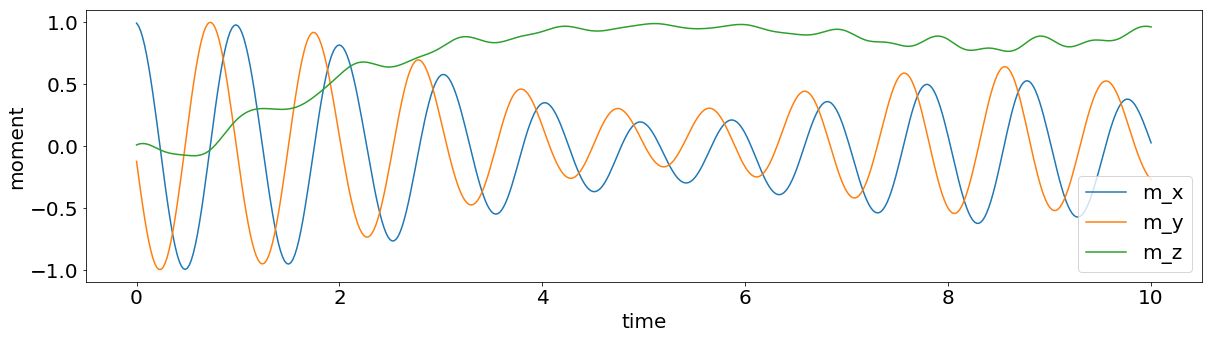

In [856]:
# Plot the figure
plt.figure(figsize=(20,5))
plt.rcParams.update({'font.size': 20})
plt.plot(t, x)
plt.plot(t, y)
plt.plot(t, z)
plt.legend(['m_x', 'm_y', 'm_z'])
plt.xlabel("time")
plt.ylabel("moment")
plt.show()

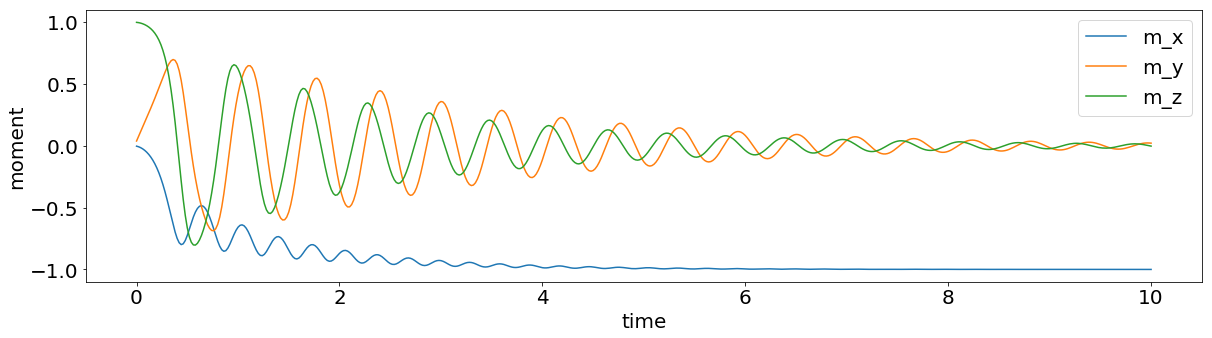

In [794]:
# Plot the figure dt = 0.02
plt.figure(figsize=(20,5))
plt.rcParams.update({'font.size': 20})
plt.plot(t, x)
plt.plot(t, y)
plt.plot(t, z)
plt.legend(['m_x', 'm_y', 'm_z'])
plt.xlabel("time")
plt.ylabel("moment")
plt.show()

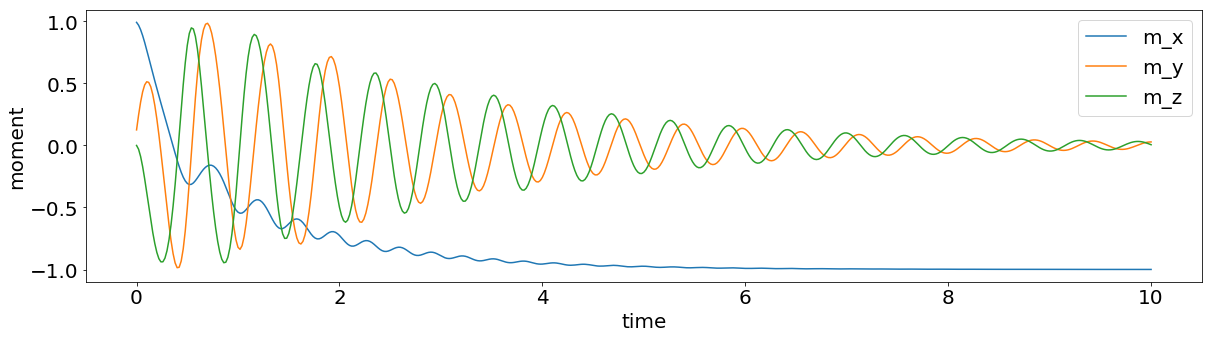

In [765]:
# Plot the figure dt = 0.01
plt.figure(figsize=(20,5))
plt.rcParams.update({'font.size': 20})
plt.plot(t, x)
plt.plot(t, y)
plt.plot(t, z)
plt.legend(['m_x', 'm_y', 'm_z'])
plt.xlabel("time")
plt.ylabel("moment")
plt.show()

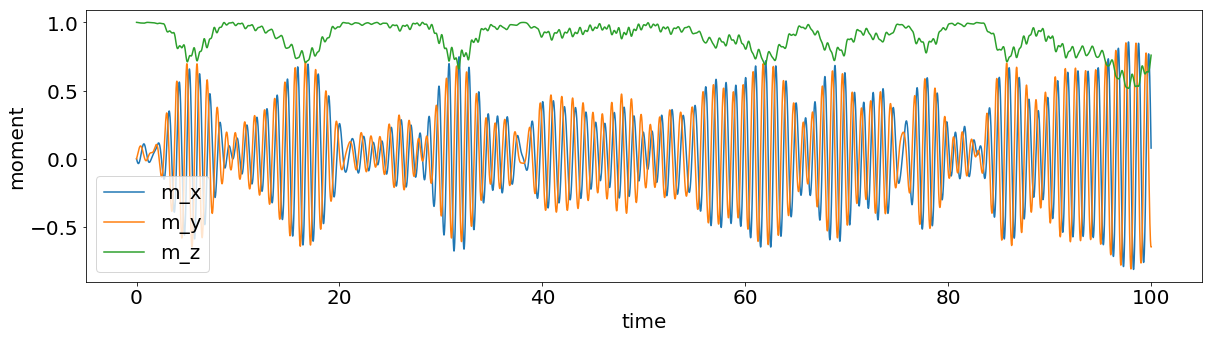

In [607]:
# Plot the figure dt = 0.001
plt.figure(figsize=(20,5))
plt.rcParams.update({'font.size': 20})
plt.plot(t, x)
plt.plot(t, y)
plt.plot(t, z)
plt.legend(['m_x', 'm_y', 'm_z'])
plt.xlabel("time")
plt.ylabel("moment")
plt.show()

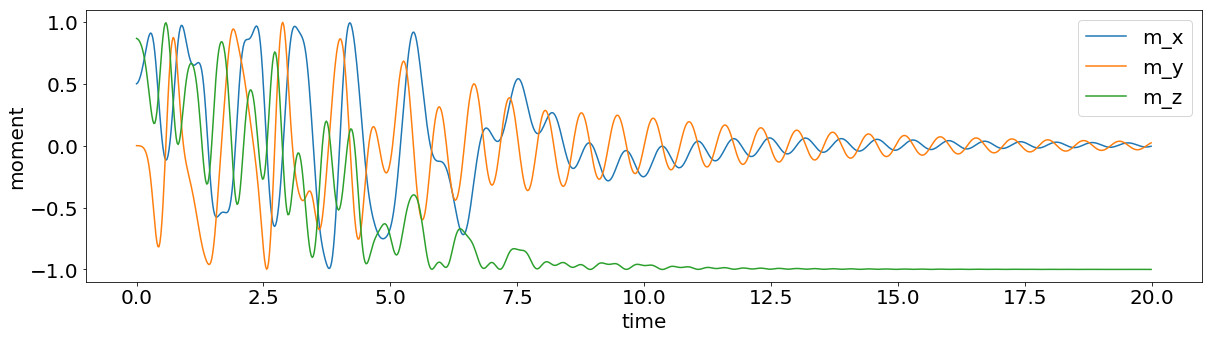

In [829]:
# Plot the figure
plt.figure(figsize=(20,5))
plt.rcParams.update({'font.size': 20})
plt.plot(t[0:1000], x[0:1000])
plt.plot(t[0:1000], y[0:1000])
plt.plot(t[0:1000], z[0:1000])
plt.legend(['m_x', 'm_y', 'm_z'])
plt.xlabel("time")
plt.ylabel("moment")
plt.show()

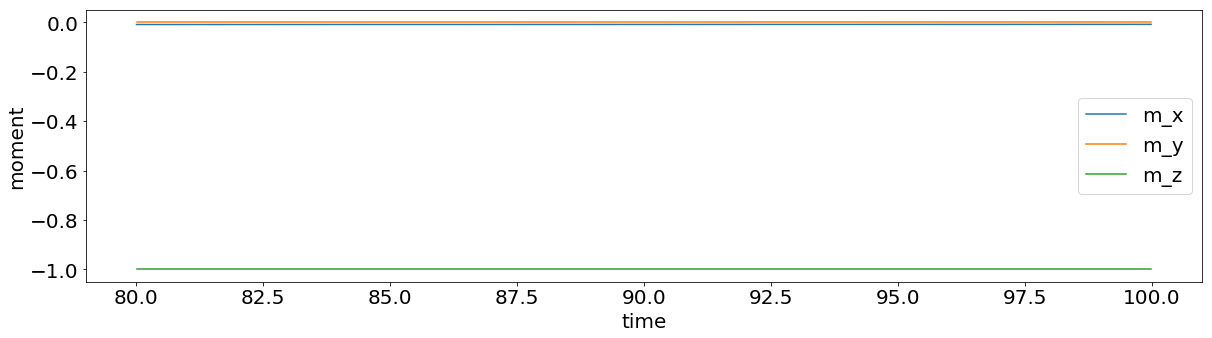

In [814]:
# Plot the figure
plt.figure(figsize=(20,5))
plt.rcParams.update({'font.size': 20})
plt.plot(t[-1000:-1], x[-1000:-1])
plt.plot(t[-1000:-1], y[-1000:-1])
plt.plot(t[-1000:-1], z[-1000:-1])
plt.legend(['m_x', 'm_y', 'm_z'])
plt.xlabel("time")
plt.ylabel("moment")
plt.show()

In [815]:
test.moments[0][0][0].B

array([1.61671118e-02, 2.31532368e-06, 1.99992206e+00])

In [536]:
1 - l[-1]

4.392691821397676e-08

In [309]:
m = moment([0, 0, 0])

theta = np.pi / 6
phi = 0

m.m = np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])
m.B = np.array([0, 0, 1])

dt = 0.002
T = np.pi * 20

N = int(T / dt) + 1

t = np.linspace(0, T, N)
dt = t[1] - t[0]

x = np.zeros(N)
y = np.zeros(N)
z = np.zeros(N)

for i in range(N):
    m.update_m(dt)
    x[i] = m.m[0]
    y[i] = m.m[1]
    z[i] = m.m[2]
    
l = np.sqrt(x**2 + y**2 + z**2)

N

TypeError: can't multiply sequence by non-int of type 'numpy.float64'

In [249]:
dtt = []
error = []

NN = [10, 100, 500, 1000, 2000, 2500, 3000, 5000, 7000, 9000, 10000]

for N in NN:
    t = np.linspace(0, np.pi * 2, N)
    dt = t[1] - t[0]

    x = np.zeros(N)
    y = np.zeros(N)
    z = np.zeros(N)
    
    theta = np.pi / 6
    phi = 0

    m.m = np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])
    m.B = np.array([0, 1, 1])

    for i in range(N):
        m.update_m(dt)
        x[i] = m.m[0]
        y[i] = m.m[1]
        z[i] = m.m[2]

    l = np.sqrt(x**2 + y**2 + z**2)
    
    dtt.append(dt)
    error.append(1 - l[-1])

    print(f'dt = {dt}, error = {1 - l[-1]}')

dt = 0.6981317007977318, error = 0.03414351062810228
dt = 0.06346651825433926, error = 2.2669288668453191e-07
dt = 0.012591553721802777, error = 6.918876582773237e-11
dt = 0.006289474781961547, error = 2.1490587087669155e-12
dt = 0.003143164235707647, error = 6.750155989720952e-14
dt = 0.002514279834805757, error = 2.453592884421596e-14
dt = 0.0020950934668821563, error = 5.662137425588298e-15
dt = 0.001256888439123742, error = 5.662137425588298e-15
dt = 0.0008977261476181721, error = 1.7763568394002505e-15
dt = 0.000698209279606577, error = -4.440892098500626e-16
dt = 0.0006283813688548441, error = -1.9984014443252818e-15


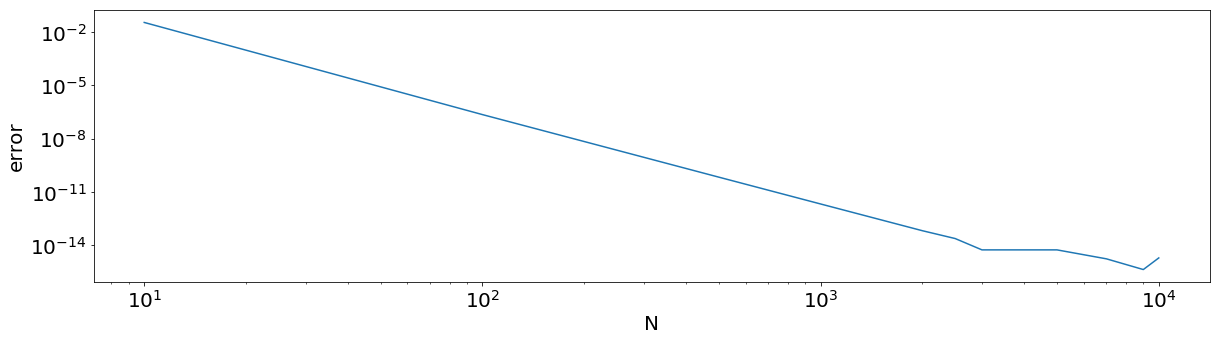

In [250]:
# Plot the figure
plt.figure(figsize=(20,5))
plt.rcParams.update({'font.size': 20})
plt.plot(NN, np.abs(error))
plt.xscale('log')
plt.yscale('log')
plt.xlabel("N")
plt.ylabel("error")
plt.show()

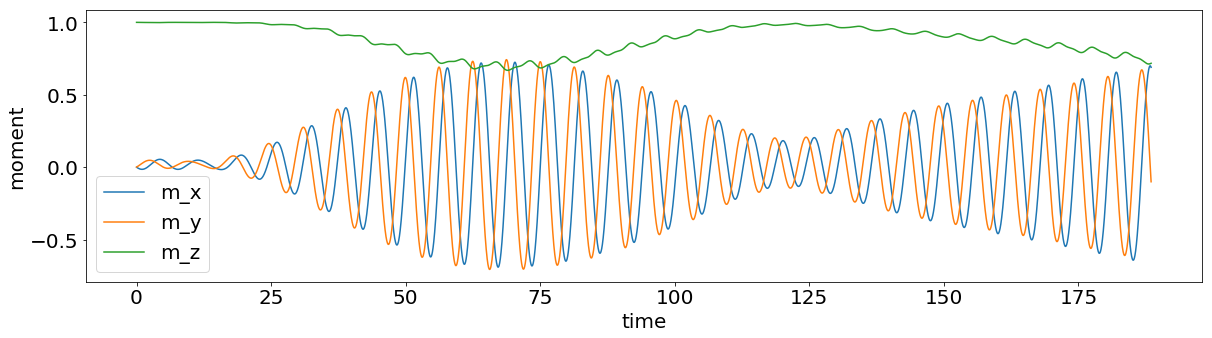

In [321]:
# Plot the figure
plt.figure(figsize=(20,5))
plt.rcParams.update({'font.size': 20})
plt.plot(t, x)
plt.plot(t, y)
plt.plot(t, z)
plt.legend(['m_x', 'm_y', 'm_z'])
plt.xlabel("time")
plt.ylabel("moment")
plt.show()

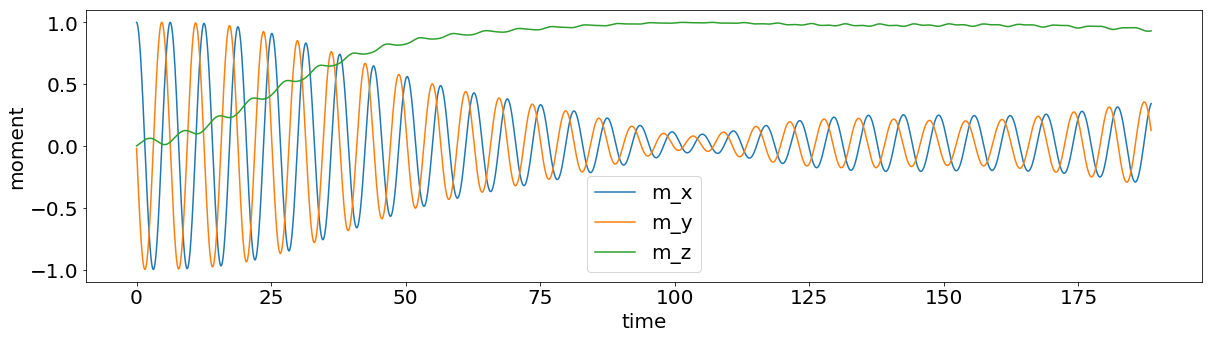

In [328]:
# Plot the figure
plt.figure(figsize=(20,5))
plt.rcParams.update({'font.size': 20})
plt.plot(t, x)
plt.plot(t, y)
plt.plot(t, z)
plt.legend(['m_x', 'm_y', 'm_z'])
plt.xlabel("time")
plt.ylabel("moment")
plt.show()

In [296]:
l_normal = l

In [301]:
l_RK4 = l

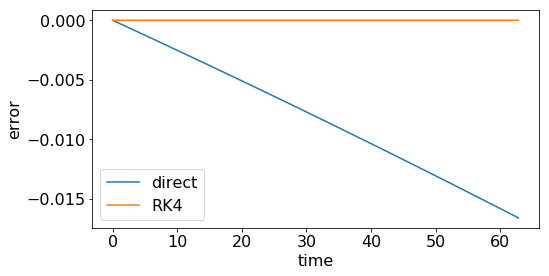

In [311]:
# Plot the figure
plt.figure(figsize=(8,4))
plt.rcParams.update({'font.size': 16})
plt.plot(t, 1 - l_normal)
plt.plot(t, 1 - l_RK4)
#plt.yscale('log')
plt.legend(['direct', 'RK4'])
plt.xlabel("time")
plt.ylabel("error")
plt.show()

In [291]:
1 - l_normal[-1]

-0.10392701173737695

In [287]:
1 - l_RK4[-1]

1.0911604952923426e-11

In [27]:
(N_1, N_2, N_3) = (3, 3, 3)
test = [[[moment([0, 0, 0]) for i in range(N_1)] for j in range(N_2)] for k in range(N_3)]

In [33]:
test[0][2][2].m

array([0, 0, 1])

3